# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

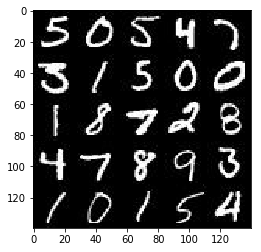

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

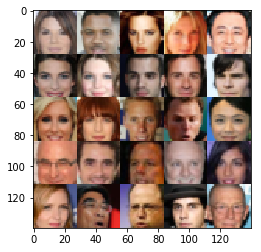

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


In [5]:
# Some fallbacks for old versions of tensorflow (1.3 on AWS)
try:
    leaky_relu = tf.nn.leaky_relu
except AttributeError:
    warnings.warn('Using fallback leaky_relu')
    def leaky_relu(inputs, alpha=0.2):
        return tf.maximum(inputs, inputs * alpha)
    

try:
    flatten = tf.layers.flatten
except AttributeError:
    warnings.warn('Using fallback flatten')
    import functools
    import operator
    
    def flatten(inputs):
        shape = inputs.get_shape()
        target_dim = functools.reduce(operator.mul, map(int, shape[1:]))
        return tf.reshape(inputs, [-1, target_dim])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: UserWarning: Using fallback leaky_relu
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: UserWarning: Using fallback flatten
  del sys.path[0]


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name='real_inputs')
    random_inputs = tf.placeholder(tf.float32, shape=[None, z_dim])
    learning_rate = tf.placeholder(tf.float32)
    is_training = tf.placeholder(tf.bool)
    return real_inputs, random_inputs, learning_rate, is_training


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ValueError: too many values to unpack (expected 3)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [17]:
KERNEL_SIZE = 3
STRIDES = 2


def conv2d(inputs, filters, is_training, normalization=True, activation=True, kernel_size=KERNEL_SIZE):
    output = tf.layers.conv2d(
        inputs=inputs, filters=filters,
        kernel_size=kernel_size, strides=STRIDES, padding='same',
        use_bias=not normalization
    )
    if normalization:
        output = tf.layers.batch_normalization(output, training=is_training)
    if activation:
        output = leaky_relu(output)
    return output
    
    
def dense(inputs, units, is_training, normalization=True, activation=True):
    output = tf.layers.dense(
        inputs=inputs, units=units, use_bias=not normalization
    )
    if normalization:
        output = tf.layers.batch_normalization(output, training=is_training)
    if activation:
        output = leaky_relu(output)
    return output
    
    
DISCRIMINATOR_DENSE_LAYERS = [2048, 256]

def discriminator(images, reuse, is_training):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        output = images
        # Shape 28x28xchannels
        output = conv2d(output, 256, is_training, normalization=False, kernel_size=5)
        # Shape is 14x14x256
        output = conv2d(output, 512, is_training)
        # Shape 7x7x512
        output = conv2d(output, 1024, is_training)
        # Shape 4x4x1024
        print('discriminator', output.get_shape())
        output = flatten(output)
        # Shape 4*4*1048 = 16K
        
        output = dense(output, 2048, is_training)
        # Shape 2K
        output = dense(output, 256, is_training)
        # Shape 256
        
        logits = dense(output, 1, is_training, normalization=False, activation=False)
        output = tf.nn.sigmoid(logits)

        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

TypeError: discriminator() missing 2 required positional arguments: 'reuse' and 'is_training'

### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [24]:
def conv2d_transpose(inputs, filters, is_training, normalization=True, activation=True, kernel_size=KERNEL_SIZE):
    output = tf.layers.conv2d_transpose(
        inputs, filters=filters,
        kernel_size=kernel_size, strides=STRIDES, padding='same',
        use_bias=not normalization
    )
    if normalization:
        output = tf.layers.batch_normalization(output, training=is_training)
    if activation:
        output = leaky_relu(output)
    return output


def generator(z, out_channel_dim, is_training, reuse=False):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=reuse):
        output = dense(z, 4 * 4 * 1024, is_training, normalization=False)
        output = tf.reshape(output, [-1, 4, 4, 1024])
        # Shape is 4x4x1024
        output = conv2d_transpose(output, 512, is_training)
        # Shape is 8x8x512
        output = conv2d_transpose(output, 256, is_training)
        # Shape ix 16x16x256
        output = conv2d_transpose(
            output, out_channel_dim, is_training,
            normalization=False, activation=False, kernel_size=5
        )
        # Shape is 32x32xout_channel_dim
        output = tf.tanh(output)
        output = tf.image.crop_to_bounding_box(output, 2, 2, 28, 28)
        print('generator out', output.get_shape())
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

TypeError: generator() missing 1 required positional argument: 'is_training'

### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim, is_training):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    generator_model = generator(input_z, out_channel_dim, is_training=is_training, reuse=False)
    discriminator_model_real, discriminator_logits_real = discriminator(
        input_real, reuse=False, is_training=is_training
    )
    discriminator_model_fake, discriminator_logits_fake = discriminator(
        generator_model, reuse=True, is_training=is_training
    )
    discriminator_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=discriminator_logits_real, labels=tf.ones_like(discriminator_logits_real)
    ))
    discriminator_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=discriminator_logits_fake, labels=tf.zeros_like(discriminator_logits_fake)
    ))
    generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=discriminator_logits_fake, labels=tf.ones_like(discriminator_logits_fake)
    ))
    discriminator_loss = discriminator_real_loss + discriminator_fake_loss
    
    return discriminator_loss, generator_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

TypeError: model_loss() missing 1 required positional argument: 'is_training'

### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    trainable_vars = tf.trainable_variables()
    discriminator_variables = [var for var in trainable_vars if var.name.startswith('discriminator')]
    generator_variables = [var for var in trainable_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        discriminator_optimizer = tf.train.AdamOptimizer(
            learning_rate=learning_rate, beta1=beta1
        ).minimize(
            d_loss, var_list=discriminator_variables
        )
        generator_optimizer = tf.train.AdamOptimizer(
            learning_rate=learning_rate, beta1=beta1
        ).minimize(
            g_loss, var_list=generator_variables
        )
    
    return discriminator_optimizer, generator_optimizer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode, is_training):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, is_training, reuse=True),
        feed_dict={input_z: example_z, is_training: False}
    )

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [19]:
PRINT_EVERY = 5
VIEW_EVERY = PRINT_EVERY * 3

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    out_channel_dim = data_shape[-1]
    real_images, z, learning_rate_tensor, is_training = model_inputs(*data_shape[1:], z_dim)
    
    discriminator_loss, generator_loss = model_loss(real_images, z, out_channel_dim, is_training=is_training)
    discriminator_opt, generator_opt = model_opt(discriminator_loss, generator_loss, learning_rate_tensor, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        step = 0
        view_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                feed_dict = {
                    real_images: batch_images,
                    z: batch_z,
                    learning_rate_tensor: learning_rate,
                    is_training: True
                }
                sess.run([discriminator_opt, generator_opt], feed_dict=feed_dict)
                if step % PRINT_EVERY == 0:
                    train_loss_discriminator = discriminator_loss.eval(feed_dict)
                    train_loss_generator = generator_loss.eval(feed_dict)
                    print(
                        'Epoch {epoch_i}/{epoch_count}: '
                        'Discriminator Loss: {train_loss_discriminator:.4f}. '
                        'Generator Loss: {train_loss_generator:.4f}'.format(
                            epoch_i=epoch_i + 1,
                            epoch_count=epoch_count,
                            train_loss_generator=train_loss_generator,
                            train_loss_discriminator=train_loss_discriminator
                        )
                    )
                if step % VIEW_EVERY == 0:
                    show_generator_output(sess, 16, z, out_channel_dim, data_image_mode, is_training)
                step += 1
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

generator out (?, 28, 28, 1)
discriminator (?, 4, 4, 1024)
discriminator (?, 4, 4, 1024)
Epoch 1/2: Discriminator Loss: 4.2308. Generator Loss: 1.9923
generator out (?, 28, 28, 1)


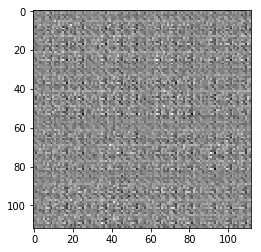

Epoch 1/2: Discriminator Loss: 1.2792. Generator Loss: 0.9579
Epoch 1/2: Discriminator Loss: 1.1001. Generator Loss: 0.9084
Epoch 1/2: Discriminator Loss: 1.0228. Generator Loss: 0.8731
generator out (?, 28, 28, 1)


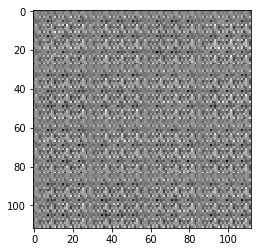

Epoch 1/2: Discriminator Loss: 0.9843. Generator Loss: 0.8855
Epoch 1/2: Discriminator Loss: 0.9845. Generator Loss: 1.0999
Epoch 1/2: Discriminator Loss: 0.9022. Generator Loss: 0.9878
generator out (?, 28, 28, 1)


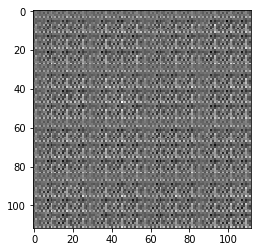

Epoch 1/2: Discriminator Loss: 0.8274. Generator Loss: 1.0398
Epoch 1/2: Discriminator Loss: 0.8474. Generator Loss: 1.1240
Epoch 1/2: Discriminator Loss: 0.8281. Generator Loss: 1.0476
generator out (?, 28, 28, 1)


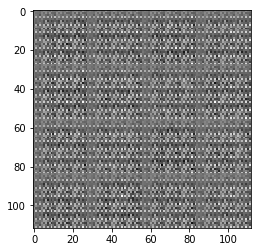

Epoch 1/2: Discriminator Loss: 0.6588. Generator Loss: 1.1721
Epoch 1/2: Discriminator Loss: 0.6498. Generator Loss: 1.1822
Epoch 1/2: Discriminator Loss: 0.6435. Generator Loss: 1.2856
generator out (?, 28, 28, 1)


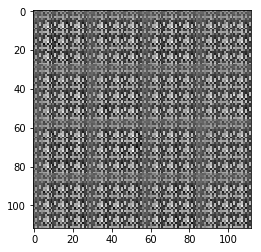

Epoch 1/2: Discriminator Loss: 0.7054. Generator Loss: 1.1940
Epoch 1/2: Discriminator Loss: 0.7078. Generator Loss: 1.2641
Epoch 1/2: Discriminator Loss: 0.7406. Generator Loss: 1.2740
generator out (?, 28, 28, 1)


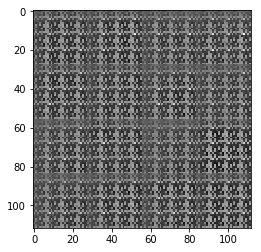

Epoch 1/2: Discriminator Loss: 0.6693. Generator Loss: 1.2781
Epoch 1/2: Discriminator Loss: 0.6150. Generator Loss: 1.2432
Epoch 1/2: Discriminator Loss: 0.6798. Generator Loss: 1.4690
generator out (?, 28, 28, 1)


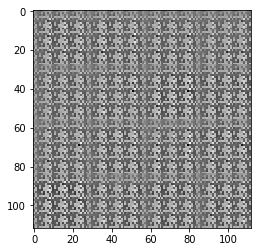

Epoch 1/2: Discriminator Loss: 0.6742. Generator Loss: 1.2827
Epoch 1/2: Discriminator Loss: 0.6189. Generator Loss: 1.3221
Epoch 1/2: Discriminator Loss: 0.5960. Generator Loss: 1.4199
generator out (?, 28, 28, 1)


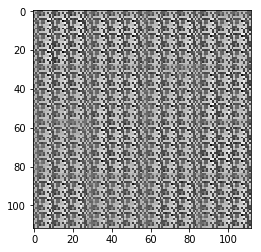

Epoch 1/2: Discriminator Loss: 0.8949. Generator Loss: 1.7491
Epoch 1/2: Discriminator Loss: 0.5808. Generator Loss: 1.4875
Epoch 1/2: Discriminator Loss: 0.6699. Generator Loss: 1.2391
generator out (?, 28, 28, 1)


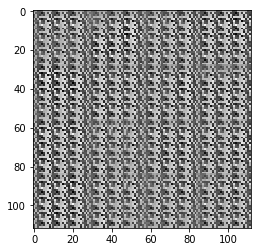

Epoch 1/2: Discriminator Loss: 0.4612. Generator Loss: 1.5022
Epoch 1/2: Discriminator Loss: 0.4371. Generator Loss: 1.3810
Epoch 1/2: Discriminator Loss: 0.5621. Generator Loss: 1.4524
generator out (?, 28, 28, 1)


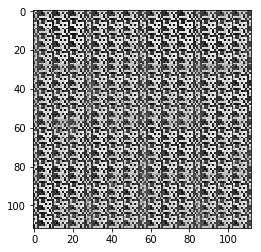

Epoch 1/2: Discriminator Loss: 0.4192. Generator Loss: 1.6285
Epoch 1/2: Discriminator Loss: 0.4286. Generator Loss: 1.5752
Epoch 1/2: Discriminator Loss: 0.5676. Generator Loss: 1.6413
generator out (?, 28, 28, 1)


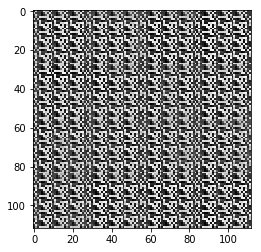

Epoch 1/2: Discriminator Loss: 0.6891. Generator Loss: 1.8232
Epoch 1/2: Discriminator Loss: 0.3674. Generator Loss: 1.7611
Epoch 1/2: Discriminator Loss: 0.4259. Generator Loss: 1.5280
generator out (?, 28, 28, 1)


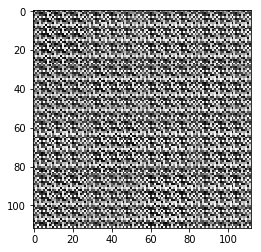

Epoch 1/2: Discriminator Loss: 0.4949. Generator Loss: 1.6084
Epoch 1/2: Discriminator Loss: 0.3038. Generator Loss: 1.8959
Epoch 1/2: Discriminator Loss: 0.2746. Generator Loss: 1.9500
generator out (?, 28, 28, 1)


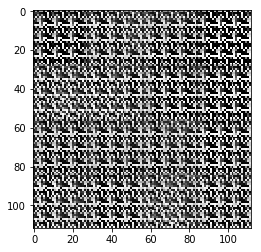

Epoch 1/2: Discriminator Loss: 0.7275. Generator Loss: 1.4817
Epoch 1/2: Discriminator Loss: 0.4202. Generator Loss: 1.7669
Epoch 1/2: Discriminator Loss: 0.3539. Generator Loss: 1.7670
generator out (?, 28, 28, 1)


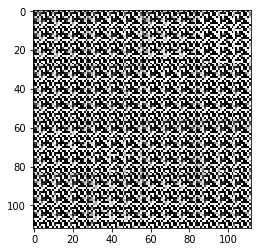

Epoch 1/2: Discriminator Loss: 0.3559. Generator Loss: 1.7782
Epoch 1/2: Discriminator Loss: 0.4469. Generator Loss: 1.4517
Epoch 1/2: Discriminator Loss: 0.3793. Generator Loss: 1.7745
generator out (?, 28, 28, 1)


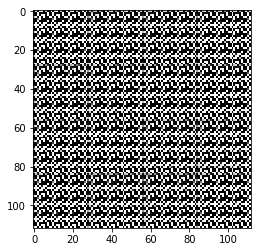

Epoch 1/2: Discriminator Loss: 0.6390. Generator Loss: 1.3760
Epoch 1/2: Discriminator Loss: 0.4317. Generator Loss: 1.5302
Epoch 1/2: Discriminator Loss: 0.4191. Generator Loss: 1.4550
generator out (?, 28, 28, 1)


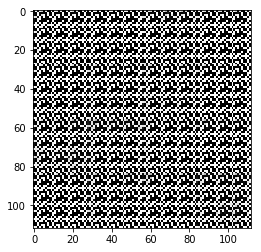

Epoch 1/2: Discriminator Loss: 0.7479. Generator Loss: 2.3105
Epoch 1/2: Discriminator Loss: 0.7597. Generator Loss: 1.1757
Epoch 1/2: Discriminator Loss: 0.5593. Generator Loss: 1.1980
generator out (?, 28, 28, 1)


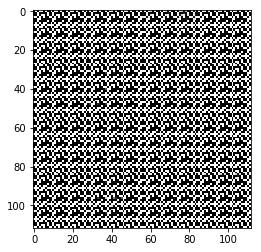

Epoch 1/2: Discriminator Loss: 0.5714. Generator Loss: 1.2414
Epoch 1/2: Discriminator Loss: 0.4497. Generator Loss: 1.3501
Epoch 1/2: Discriminator Loss: 0.4334. Generator Loss: 1.4121
generator out (?, 28, 28, 1)


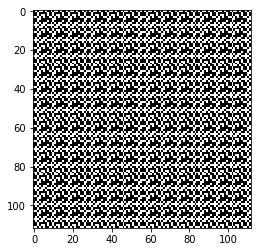

Epoch 1/2: Discriminator Loss: 0.4636. Generator Loss: 1.3181
Epoch 1/2: Discriminator Loss: 0.5338. Generator Loss: 1.4677
Epoch 1/2: Discriminator Loss: 0.4139. Generator Loss: 1.4249
generator out (?, 28, 28, 1)


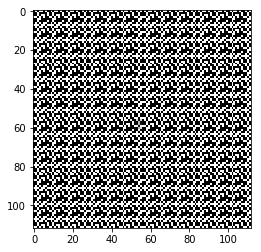

Epoch 1/2: Discriminator Loss: 0.4250. Generator Loss: 1.4165
Epoch 1/2: Discriminator Loss: 0.3719. Generator Loss: 1.5374
Epoch 1/2: Discriminator Loss: 0.3296. Generator Loss: 1.5912
generator out (?, 28, 28, 1)


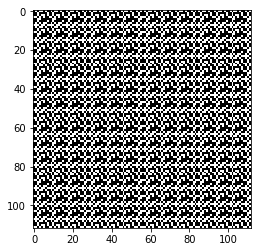

Epoch 1/2: Discriminator Loss: 0.3012. Generator Loss: 1.6938
Epoch 1/2: Discriminator Loss: 0.3037. Generator Loss: 1.7200
Epoch 1/2: Discriminator Loss: 0.3095. Generator Loss: 1.5379
generator out (?, 28, 28, 1)


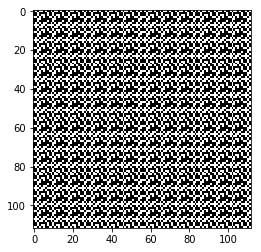

Epoch 1/2: Discriminator Loss: 0.3308. Generator Loss: 1.5844
Epoch 1/2: Discriminator Loss: 0.3114. Generator Loss: 1.5986
Epoch 1/2: Discriminator Loss: 0.2495. Generator Loss: 1.8912
generator out (?, 28, 28, 1)


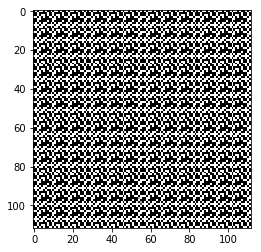

Epoch 1/2: Discriminator Loss: 0.3308. Generator Loss: 1.7839
Epoch 1/2: Discriminator Loss: 0.2734. Generator Loss: 1.7212
Epoch 1/2: Discriminator Loss: 0.2399. Generator Loss: 1.9837
generator out (?, 28, 28, 1)


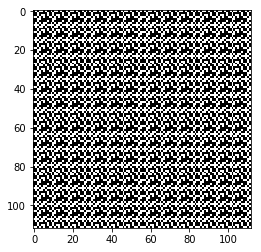

Epoch 1/2: Discriminator Loss: 0.2873. Generator Loss: 2.0235
Epoch 1/2: Discriminator Loss: 0.2099. Generator Loss: 2.1313
Epoch 1/2: Discriminator Loss: 0.3416. Generator Loss: 1.7079
generator out (?, 28, 28, 1)


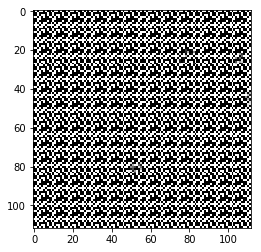

Epoch 1/2: Discriminator Loss: 0.2560. Generator Loss: 1.7337
Epoch 1/2: Discriminator Loss: 0.2631. Generator Loss: 1.9729
Epoch 1/2: Discriminator Loss: 0.2542. Generator Loss: 1.9189
generator out (?, 28, 28, 1)


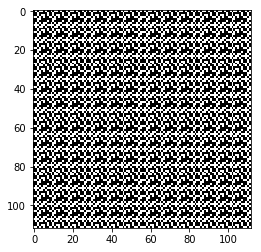

Epoch 1/2: Discriminator Loss: 0.2220. Generator Loss: 1.8598
Epoch 1/2: Discriminator Loss: 0.1807. Generator Loss: 2.1595
Epoch 1/2: Discriminator Loss: 0.1945. Generator Loss: 2.1168
generator out (?, 28, 28, 1)


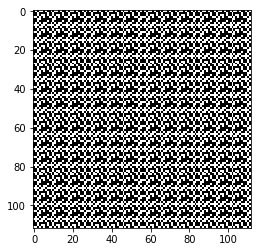

Epoch 1/2: Discriminator Loss: 0.1634. Generator Loss: 2.1238
Epoch 1/2: Discriminator Loss: 0.1932. Generator Loss: 1.9717
Epoch 1/2: Discriminator Loss: 0.1855. Generator Loss: 2.1879
generator out (?, 28, 28, 1)


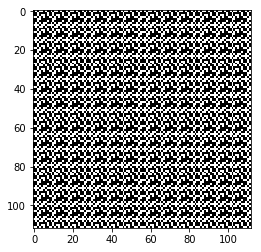

Epoch 1/2: Discriminator Loss: 0.1515. Generator Loss: 2.3297
Epoch 1/2: Discriminator Loss: 0.5181. Generator Loss: 2.0250
Epoch 1/2: Discriminator Loss: 0.2544. Generator Loss: 2.1165
generator out (?, 28, 28, 1)


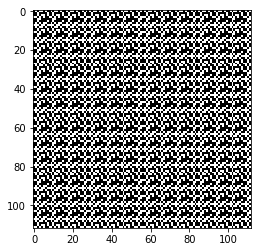

Epoch 1/2: Discriminator Loss: 0.2544. Generator Loss: 1.9838
Epoch 1/2: Discriminator Loss: 0.2105. Generator Loss: 1.9603
Epoch 1/2: Discriminator Loss: 0.2023. Generator Loss: 1.9875
generator out (?, 28, 28, 1)


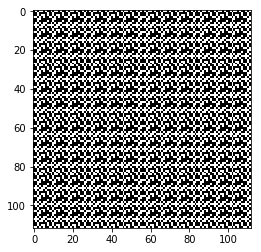

Epoch 1/2: Discriminator Loss: 0.1816. Generator Loss: 2.1978
Epoch 1/2: Discriminator Loss: 0.1774. Generator Loss: 2.0397
Epoch 1/2: Discriminator Loss: 0.3633. Generator Loss: 2.2764
generator out (?, 28, 28, 1)


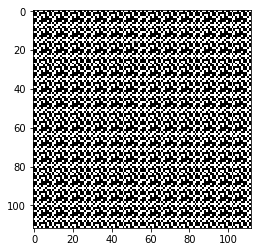

Epoch 1/2: Discriminator Loss: 0.3502. Generator Loss: 2.2225
Epoch 1/2: Discriminator Loss: 0.1550. Generator Loss: 2.3366
Epoch 1/2: Discriminator Loss: 0.1536. Generator Loss: 2.2004
generator out (?, 28, 28, 1)


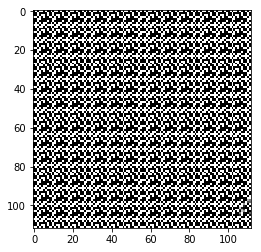

Epoch 1/2: Discriminator Loss: 0.1742. Generator Loss: 2.3210
Epoch 1/2: Discriminator Loss: 0.1302. Generator Loss: 2.5241
Epoch 1/2: Discriminator Loss: 0.1175. Generator Loss: 2.5040
generator out (?, 28, 28, 1)


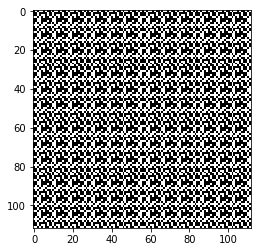

Epoch 2/2: Discriminator Loss: 0.1944. Generator Loss: 3.0850
Epoch 2/2: Discriminator Loss: 0.5716. Generator Loss: 1.8548
Epoch 2/2: Discriminator Loss: 0.5867. Generator Loss: 2.0587
generator out (?, 28, 28, 1)


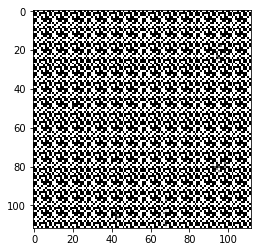

Epoch 2/2: Discriminator Loss: 0.3442. Generator Loss: 2.1751
Epoch 2/2: Discriminator Loss: 0.2179. Generator Loss: 1.9526
Epoch 2/2: Discriminator Loss: 0.1906. Generator Loss: 2.4598
generator out (?, 28, 28, 1)


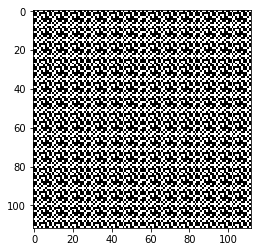

Epoch 2/2: Discriminator Loss: 0.1852. Generator Loss: 2.8718
Epoch 2/2: Discriminator Loss: 0.1684. Generator Loss: 2.5402
Epoch 2/2: Discriminator Loss: 0.2083. Generator Loss: 2.6684
generator out (?, 28, 28, 1)


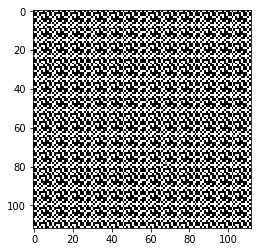

Epoch 2/2: Discriminator Loss: 0.1769. Generator Loss: 2.7877
Epoch 2/2: Discriminator Loss: 0.1611. Generator Loss: 2.5377
Epoch 2/2: Discriminator Loss: 0.3279. Generator Loss: 1.9254
generator out (?, 28, 28, 1)


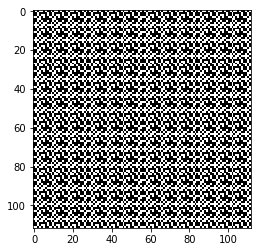

Epoch 2/2: Discriminator Loss: 0.2561. Generator Loss: 2.5770
Epoch 2/2: Discriminator Loss: 0.1406. Generator Loss: 3.1298
Epoch 2/2: Discriminator Loss: 0.1487. Generator Loss: 2.8917
generator out (?, 28, 28, 1)


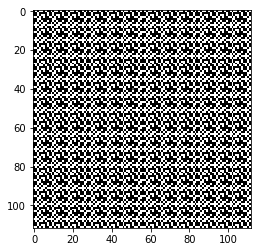

Epoch 2/2: Discriminator Loss: 0.2488. Generator Loss: 2.5325
Epoch 2/2: Discriminator Loss: 0.4893. Generator Loss: 1.4008
Epoch 2/2: Discriminator Loss: 0.4575. Generator Loss: 2.1115
generator out (?, 28, 28, 1)


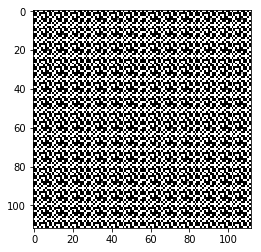

Epoch 2/2: Discriminator Loss: 0.3247. Generator Loss: 1.7260
Epoch 2/2: Discriminator Loss: 0.2518. Generator Loss: 1.9716
Epoch 2/2: Discriminator Loss: 0.1551. Generator Loss: 2.6877
generator out (?, 28, 28, 1)


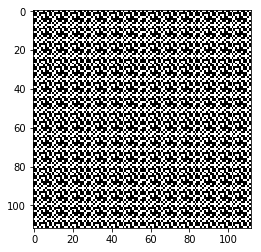

Epoch 2/2: Discriminator Loss: 0.1580. Generator Loss: 2.7333
Epoch 2/2: Discriminator Loss: 0.1858. Generator Loss: 2.1004
Epoch 2/2: Discriminator Loss: 0.1850. Generator Loss: 2.2254
generator out (?, 28, 28, 1)


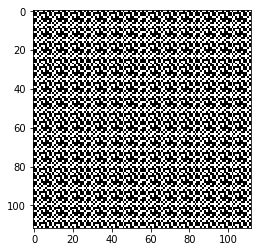

Epoch 2/2: Discriminator Loss: 0.1591. Generator Loss: 2.5826
Epoch 2/2: Discriminator Loss: 0.1520. Generator Loss: 2.7482
Epoch 2/2: Discriminator Loss: 0.1489. Generator Loss: 2.6527
generator out (?, 28, 28, 1)


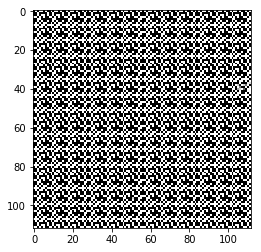

Epoch 2/2: Discriminator Loss: 0.1005. Generator Loss: 3.1472
Epoch 2/2: Discriminator Loss: 0.1787. Generator Loss: 2.2302
Epoch 2/2: Discriminator Loss: 0.2421. Generator Loss: 2.3311
generator out (?, 28, 28, 1)


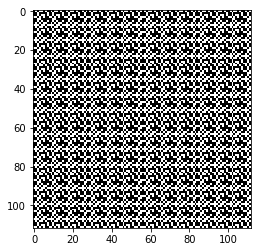

Epoch 2/2: Discriminator Loss: 0.1298. Generator Loss: 2.4088
Epoch 2/2: Discriminator Loss: 0.1480. Generator Loss: 2.4779
Epoch 2/2: Discriminator Loss: 0.1546. Generator Loss: 2.5277
generator out (?, 28, 28, 1)


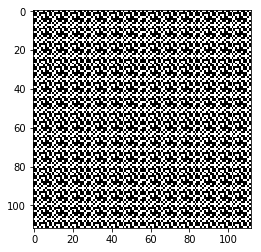

Epoch 2/2: Discriminator Loss: 0.1571. Generator Loss: 2.6866
Epoch 2/2: Discriminator Loss: 0.1110. Generator Loss: 2.8075
Epoch 2/2: Discriminator Loss: 0.1121. Generator Loss: 2.7076
generator out (?, 28, 28, 1)


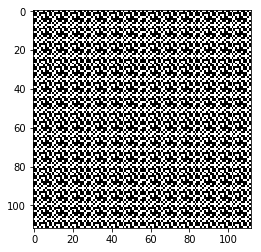

Epoch 2/2: Discriminator Loss: 0.1108. Generator Loss: 2.6958
Epoch 2/2: Discriminator Loss: 0.4631. Generator Loss: 2.2956
Epoch 2/2: Discriminator Loss: 0.2210. Generator Loss: 2.0437
generator out (?, 28, 28, 1)


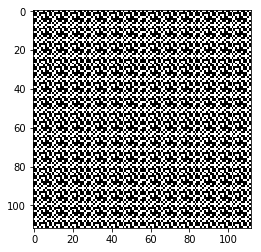

Epoch 2/2: Discriminator Loss: 0.1950. Generator Loss: 2.0735
Epoch 2/2: Discriminator Loss: 0.1914. Generator Loss: 2.1234
Epoch 2/2: Discriminator Loss: 0.2293. Generator Loss: 2.1937
generator out (?, 28, 28, 1)


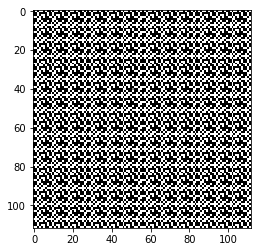

Epoch 2/2: Discriminator Loss: 0.1398. Generator Loss: 2.8086
Epoch 2/2: Discriminator Loss: 0.2169. Generator Loss: 2.5000
Epoch 2/2: Discriminator Loss: 0.1603. Generator Loss: 2.4493
generator out (?, 28, 28, 1)


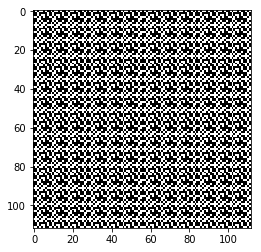

Epoch 2/2: Discriminator Loss: 0.1774. Generator Loss: 2.3043
Epoch 2/2: Discriminator Loss: 0.1558. Generator Loss: 2.7412
Epoch 2/2: Discriminator Loss: 0.1675. Generator Loss: 2.8376
generator out (?, 28, 28, 1)


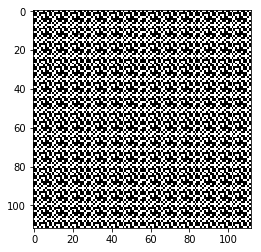

Epoch 2/2: Discriminator Loss: 0.1240. Generator Loss: 3.1072
Epoch 2/2: Discriminator Loss: 0.1431. Generator Loss: 2.4351
Epoch 2/2: Discriminator Loss: 0.1074. Generator Loss: 2.8790
generator out (?, 28, 28, 1)


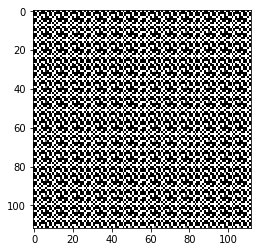

Epoch 2/2: Discriminator Loss: 0.1108. Generator Loss: 2.8108
Epoch 2/2: Discriminator Loss: 0.0851. Generator Loss: 2.9528
Epoch 2/2: Discriminator Loss: 0.1007. Generator Loss: 2.8890
generator out (?, 28, 28, 1)


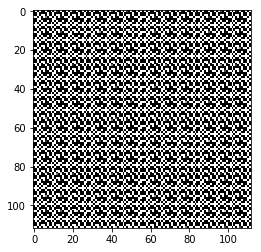

Epoch 2/2: Discriminator Loss: 0.0942. Generator Loss: 3.0142
Epoch 2/2: Discriminator Loss: 0.1027. Generator Loss: 2.9838
Epoch 2/2: Discriminator Loss: 0.0932. Generator Loss: 2.9776
generator out (?, 28, 28, 1)


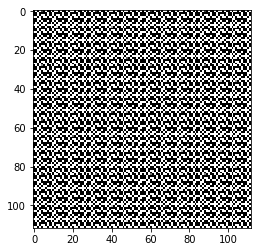

Epoch 2/2: Discriminator Loss: 0.1079. Generator Loss: 2.9626
Epoch 2/2: Discriminator Loss: 0.0999. Generator Loss: 3.4523
Epoch 2/2: Discriminator Loss: 0.4694. Generator Loss: 2.9042
generator out (?, 28, 28, 1)


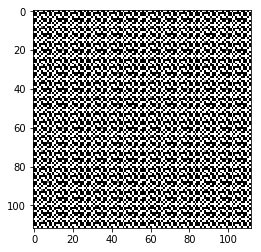

Epoch 2/2: Discriminator Loss: 0.1289. Generator Loss: 2.8810
Epoch 2/2: Discriminator Loss: 0.1130. Generator Loss: 2.8588
Epoch 2/2: Discriminator Loss: 0.0973. Generator Loss: 2.9486
generator out (?, 28, 28, 1)


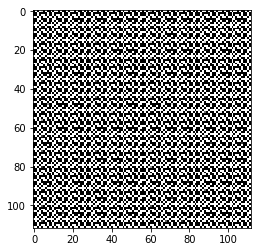

Epoch 2/2: Discriminator Loss: 0.1260. Generator Loss: 2.9103
Epoch 2/2: Discriminator Loss: 0.1373. Generator Loss: 2.8580
Epoch 2/2: Discriminator Loss: 0.0866. Generator Loss: 3.0372
generator out (?, 28, 28, 1)


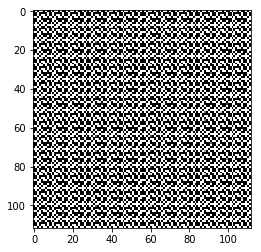

Epoch 2/2: Discriminator Loss: 0.0907. Generator Loss: 3.3907
Epoch 2/2: Discriminator Loss: 0.0826. Generator Loss: 3.4823
Epoch 2/2: Discriminator Loss: 0.0873. Generator Loss: 3.1161
generator out (?, 28, 28, 1)


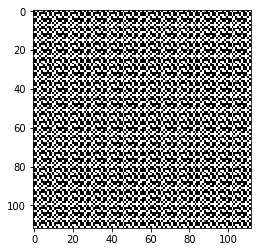

Epoch 2/2: Discriminator Loss: 0.1526. Generator Loss: 3.3509
Epoch 2/2: Discriminator Loss: 0.1724. Generator Loss: 3.4361
Epoch 2/2: Discriminator Loss: 0.0949. Generator Loss: 3.3336
generator out (?, 28, 28, 1)


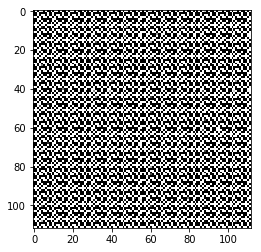

Epoch 2/2: Discriminator Loss: 0.0770. Generator Loss: 3.2613
Epoch 2/2: Discriminator Loss: 0.0642. Generator Loss: 3.6087
Epoch 2/2: Discriminator Loss: 0.0761. Generator Loss: 3.4311
generator out (?, 28, 28, 1)


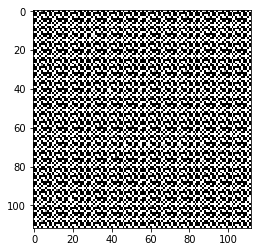

Epoch 2/2: Discriminator Loss: 0.1324. Generator Loss: 3.4908
Epoch 2/2: Discriminator Loss: 0.1776. Generator Loss: 3.1368
Epoch 2/2: Discriminator Loss: 0.0966. Generator Loss: 3.2348
generator out (?, 28, 28, 1)


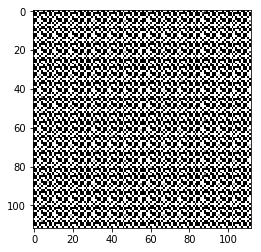

Epoch 2/2: Discriminator Loss: 0.1390. Generator Loss: 2.9208
Epoch 2/2: Discriminator Loss: 0.0678. Generator Loss: 3.3127
Epoch 2/2: Discriminator Loss: 0.0786. Generator Loss: 3.0167
generator out (?, 28, 28, 1)


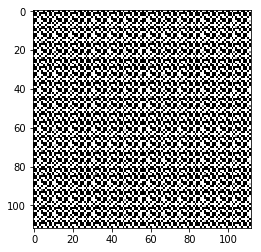

Epoch 2/2: Discriminator Loss: 0.0794. Generator Loss: 3.3144
Epoch 2/2: Discriminator Loss: 0.0597. Generator Loss: 3.5367
Epoch 2/2: Discriminator Loss: 0.0876. Generator Loss: 3.0988
generator out (?, 28, 28, 1)


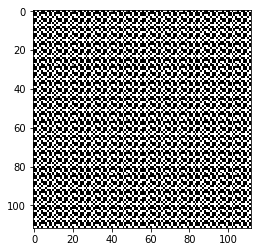

Epoch 2/2: Discriminator Loss: 0.1163. Generator Loss: 3.8114
Epoch 2/2: Discriminator Loss: 0.1737. Generator Loss: 3.1261
Epoch 2/2: Discriminator Loss: 0.1693. Generator Loss: 2.8844
generator out (?, 28, 28, 1)


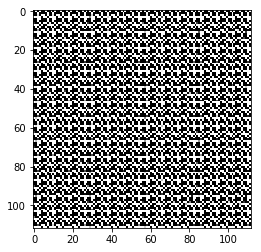

Epoch 2/2: Discriminator Loss: 0.0989. Generator Loss: 2.9730
Epoch 2/2: Discriminator Loss: 0.1024. Generator Loss: 2.9860
Epoch 2/2: Discriminator Loss: 0.0727. Generator Loss: 3.2841
generator out (?, 28, 28, 1)


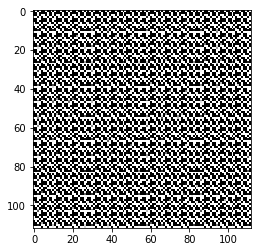

Epoch 2/2: Discriminator Loss: 0.0946. Generator Loss: 3.0793
Epoch 2/2: Discriminator Loss: 0.1662. Generator Loss: 3.3320
Epoch 2/2: Discriminator Loss: 0.0922. Generator Loss: 3.3153
generator out (?, 28, 28, 1)


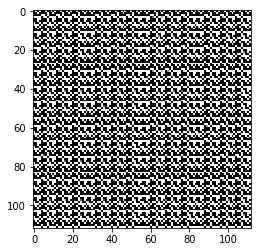

Epoch 2/2: Discriminator Loss: 0.0965. Generator Loss: 3.3906


In [25]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = None
z_dim = None
learning_rate = None
beta1 = None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.